In [1]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('selected_data.csv')
data['GDatetime'] = pd.to_datetime(data['GDatetime'])
data.set_index('GDatetime', inplace=True)
data

,F_RunState,F_CycleTime,F_SpindleRPM1,F_SpindleTroq1,F_SpindleGearRatio1,F_ToolNum,G_ADC1,G_ADC2,G_ADC3,G_MV,G_MA,G_MActP,G_MFeq,G_MTemp,label,anomaly
GDatetime,,,,,,,,,,,,,,,,
2023-06-05 07:03:45,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,222.020004,2.974,0.924,59.970001,39.0,0,0
2023-06-05 07:03:46,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:47,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:48,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,220.729996,2.976,0.920,59.959999,39.0,0,0
2023-06-05 07:03:49,2.0,0.0,0.0,0.0,0.0,0.0,24.299999,43.700001,0.0,221.630005,2.962,0.920,59.959999,39.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 16:27:16,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.570007,11.092,2.656,59.970001,45.0,363,0
2023-07-01 16:27:17,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0
2023-07-01 16:27:18,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0


In [3]:
def find_cycle_periods(data, threshold_low=100, threshold_high=10000, sub_cycle_threshold=1000, sub_cycle_length_minutes=50):
    cycle_starts = []
    cycle_ends = []
    in_cycle = False
    in_high = False
    in_sub_cycle = False
    label = -1 # 주기 라벨 (0부터 시작)
    
    # label 열을 추가하고 -1로 초기화
    data['label'] = 0
    sub_cycle_start_time = None
    sub_cycle_length = 0
    
    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]
        next_value = data['F_CycleTime'].iloc[i + 1]
        
        # 주기 시작 지점 찾기 (0 ~ 100 근처에서 올라가기 시작)
        if not in_cycle and value <= threshold_low:
            in_cycle = True
            label += 1 # 새로운 주기 시작, 라벨 증가
            cycle_starts.append(data.index[i]) # datetime 인덱스 사용
        
        # 주기 내부라면 현재 라벨로 표시
        if in_cycle:
            data['label'].iloc[i] = label

        # 1만 근처의 값에 도달
        if in_cycle and not in_high and value >= threshold_high:
            in_high = True

        # 1천 근처의 값에 도달
        if in_cycle and not in_high and value >= sub_cycle_threshold:
            in_sub_cycle = True
            if sub_cycle_start_time is None:
                sub_cycle_start_time = data.index[i]

        # 하위 주기의 끝 지점 찾기
        if in_sub_cycle and next_value <= threshold_low:
            sub_cycle_length += (data.index[i] - sub_cycle_start_time).seconds / 60
            sub_cycle_start_time = None
            if sub_cycle_length >= sub_cycle_length_minutes:
                in_high = True
            in_sub_cycle = False
            
        # 주기 끝 지점 찾기
        if in_high and next_value <= threshold_low:
            in_high = False
            in_cycle = False
            cycle_ends.append(data.index[i]) # datetime 인덱스 사용
            sub_cycle_length = 0
            
    # 마지막 주기의 끝 지점 처리
    if in_cycle:
        cycle_ends.append(data.index[-1])

    return cycle_starts, cycle_ends


def remove_constant_values(data, lower_bound=1000, upper_bound=12000, duration_minutes=20):
    constant_value = None
    constant_start_time = None
    rows_to_drop = []

    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]

        # 값이 범위 내에 있고 이전 값과 동일한 경우
        if lower_bound <= value < upper_bound and value == constant_value:
            if constant_start_time is None:
                constant_start_time = data.index[i]
            # 지속 시간이 20분 이상인 경우
            if (data.index[i] - constant_start_time).seconds / 60 >= duration_minutes:
                rows_to_drop.append(data.index[i])
        else:
            constant_value = value
            constant_start_time = None

    # 행 삭제
    data.drop(rows_to_drop, inplace=True)
    return data



selected_data = data

selected_data = remove_constant_values(selected_data)

# 중복된 인덱스를 가진 행의 평균값으로 병합
selected_data = selected_data.groupby(selected_data.index).mean()

cycle_starts, cycle_ends = find_cycle_periods(selected_data)

selected_data = selected_data.iloc[:-1]
selected_data['anomaly'] = 0
specific_labels = [43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]
selected_data.loc[selected_data['label'].isin(specific_labels), 'anomaly'] = 1

# feature_columns에 넣고 싶은 특징 넣으면 됨.

In [4]:
# 최대 샘플 길이를 정의 (선택적)
max_length = max(len(selected_data.loc[start:end]) for start, end in zip(cycle_starts, cycle_ends))

def create_3d_array(data, cycle_starts, cycle_ends, max_length=None, 
                    feature_columns=['F_RunState', 'F_ToolNum', 'F_CycleTime', 'F_SpindleRPM1', 'F_SpindleTroq1', 'G_ADC1', 'G_ADC2', 'G_ADC3', 'G_MV', 'G_MActP', 'G_MTemp', 'anomaly']):
    # 주기별 샘플을 저장할 리스트
    samples = []

    # 각 주기를 샘플로 변환
    for start, end in zip(cycle_starts, cycle_ends):
        sample = data.loc[start:end][feature_columns].values
        
        # 샘플 길이 통일 (선택적)
        if max_length:
            if len(sample) > max_length:
                sample = sample[:max_length]
            elif len(sample) < max_length:
                padding = np.zeros((max_length - len(sample), len(feature_columns)))
                sample = np.vstack((sample, padding))
        
        samples.append(sample)

    # 샘플들을 3차원 배열로 쌓기
    samples_array = np.stack(samples)
    
    return samples_array

# 3차원 배열 생성
samples_array = create_3d_array(selected_data, cycle_starts, cycle_ends, max_length=max_length)

# 결과의 형태 출력
X = samples_array[:,:,:-1]
y = samples_array[:,0,-1]
X.shape, y.shape

((364, 7005, 11), (364,))

# 280은 마지막 1주 정도를 test set으로 사용하기 위함.
# 스케일러, split 원하는 대로 알아서 해보길.

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train_val = X[:280]
y_train_val = y[:280]
X_test = X[280:]
y_test = y[280:]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)

std = StandardScaler()
mm = MinMaxScaler()

# 초기화
X_train_sc = []
X_val_sc = []
X_test_sc = []

# 학습 데이터 변환
for sample in X_train:
    mm_sample = mm.fit_transform(sample[:, :2])
    std_sample = std.fit_transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_train_sc.append(sc_sample)

# 검증 데이터 변환
for sample in X_val:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_val_sc.append(sc_sample)

# 테스트 데이터 변환
for sample in X_test:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_test_sc.append(sc_sample)

# NumPy 배열로 변환
X_train_sc = np.array(X_train_sc)
X_val_sc = np.array(X_val_sc)
X_test_sc = np.array(X_test_sc)

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, Cropping1D

# 입력 형태 설정
input_shape = (7005, 11)  # 샘플 길이 7005, 특징 개수 11

# 인코더 부분
input_layer = Input(shape=input_shape)
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# 디코더 부분
x = Conv1DTranspose(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1DTranspose(11, 3, activation='sigmoid', padding='same')(x)

# 출력 크기를 원래 입력 크기와 동일하게 조정 (Cropping)
decoded = Cropping1D(cropping=(0, 3))(x)  # 출력 크기를 7005로 조정

# 모델 구성
autoencoder = Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 구조 출력
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7005, 11)]        0         
                                                                 
 conv1d_12 (Conv1D)          (None, 7005, 64)          2176      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 3503, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 3503, 32)          6176      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1752, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_transpose_3 (Conv1D  (None, 1752, 32)          3104

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_sc, X_train_sc, validation_split=0.2, batch_size=128, epochs=300, callbacks=[es_callback])

Epoch 1/300
2/2 [==============================] - 95s 2s/step - loss: 1.0457 - val_loss: 1.0271
Epoch 2/300
2/2 [==============================] - 2s 613ms/step - loss: 1.0251 - val_loss: 1.0061
Epoch 3/300
2/2 [==============================] - 2s 554ms/step - loss: 1.0037 - val_loss: 0.9790
Epoch 4/300
2/2 [==============================] - 2s 569ms/step - loss: 0.9758 - val_loss: 0.9426
Epoch 5/300
2/2 [==============================] - 2s 559ms/step - loss: 0.9383 - val_loss: 0.8957
Epoch 6/300
2/2 [==============================] - 2s 576ms/step - loss: 0.8905 - val_loss: 0.8399
Epoch 7/300
2/2 [==============================] - 2s 590ms/step - loss: 0.8339 - val_loss: 0.7795
Epoch 8/300
2/2 [==============================] - 2s 573ms/step - loss: 0.7727 - val_loss: 0.7195
Epoch 9/300
2/2 [==============================] - 2s 525ms/step - loss: 0.7126 - val_loss: 0.6676
Epoch 10/300
2/2 [==============================] - 2s 518ms/step - loss: 0.6611 - val_loss: 0.6285
Epoch 11/30

In [59]:
p_val = autoencoder.predict(X_val_sc)
p_test = autoencoder.predict(X_test_sc)
p_val.shape, p_test.shape

3/3 [==============================] - 0s 112ms/step


((84, 7005, 11), (84, 7005, 11))

In [32]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Modified rce shape: (84,)


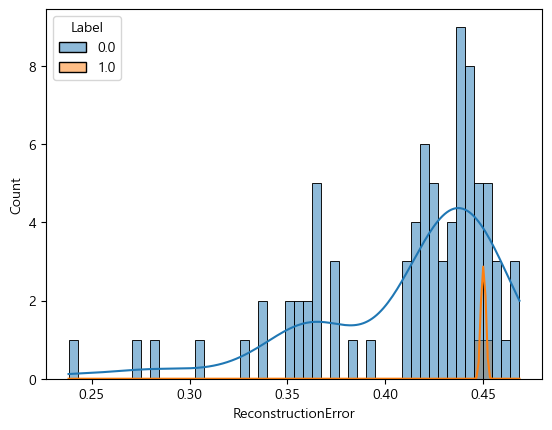

In [60]:
# 재건 에러 계산 함수
def reconstruction_error(x, p):
    return np.mean(np.abs(x - p), axis=(1, -1))

rce = reconstruction_error(X_test_sc, p_test)
print(f"Modified rce shape: {rce.shape}")

# rce와 y_val을 하나의 DataFrame으로 만듭니다.
df = pd.DataFrame({'ReconstructionError': rce, 'Label': y_val})

# 히스토그램을 그립니다.
plt.figure()
sns.histplot(data=df, x='ReconstructionError', hue='Label', bins=50, kde=True)
plt.show()


In [49]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

정확도: 0.9285714285714286
F1 점수: 0.0
[[78  0]
 [ 6  0]]


<Figure size 640x480 with 0 Axes>

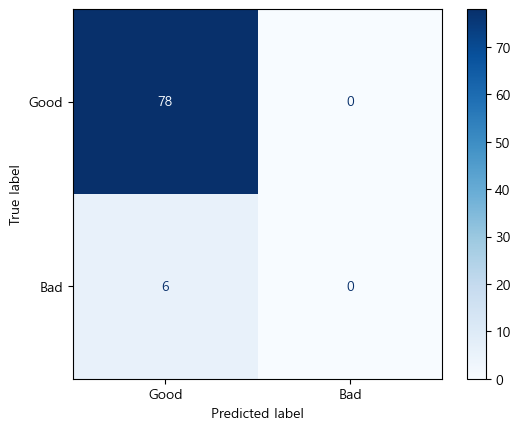

In [61]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix

# 임계값 설정, 이 값은 문제에 따라 다르게 설정해야 할 수 있습니다.
threshold = 0.5

# 재구성 에러 계산
rce = reconstruction_error(X_test_sc, p_test)

# 재구성 에러가 임계값보다 큰 경우를 'Bad'(1)로, 그렇지 않은 경우를 'Good'(0)으로 분류
p_val_bin = (rce > threshold).astype(int)

# 이제 p_val_bin과 y_val의 차원이 일치하므로, 평가 메트릭을 계산할 수 있습니다.
print('정확도:', accuracy_score(y_test, p_val_bin))
print('F1 점수:', f1_score(y_test, p_val_bin))
print(confusion_matrix(y_test, p_val_bin))
plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, p_val_bin), display_labels=['Good', 'Bad']).plot(cmap='Blues')
plt.show()
